# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 30

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Преобразуем заголовки столбцов в формат нижнего регистра с символом подчеркивания между словами

In [3]:
def split_word(text): 
    list_=[]
    for i in range(len(text)):
        if text[i].isupper():
            list_.append(' '+ text[i])
        else:
            list_.append(text[i])
    return ((''.join(list_).lower().strip()).replace(' ','_'))

data.columns = [split_word(i) for i in data.columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
registration_year,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
registration_month,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
number_of_pictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
postal_code,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"


**Комментарий:** Так как для оценки качества моделей применяйте метрику RMSE, требуется посмотреть выбросы. Плюс есть пропуски, которые требуют обратботки, а также оценка дубликатов.

### Проверка дубликатов

In [6]:
duplicates = data[data.duplicated(keep=False)] 
display(duplicates)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [7]:
data = data.drop_duplicates().reset_index(drop=True)

**Комментарий:** Выявлено 4 полных дубликата, удалены

### Оценка пропусков

- из массовых пропусков значений (NaN) можно  отменить такие поля : vehicle_type, fuel_type, not_repaired. Признаки категориальные поэтому замена с помощью статистических методов оценки (mean,median,moda т.д.) затруднительна.
- в таргете поле price пропусков нет
- заменим отсутствующие значения по категориям на значения "not defined" - не определено

In [8]:
data[['vehicle_type','not_repaired','fuel_type','model','gearbox']] =data[['vehicle_type','not_repaired','fuel_type','model','gearbox']].fillna('not defined')

### Оценка  выбросов и аномальных значений

#### Оценка поля registration_year (год регистрации автомобиля)

**Комментарий:** поле **registration_year**  присутвуют значения , которые отличаются  от привычного летоисчисления

In [9]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

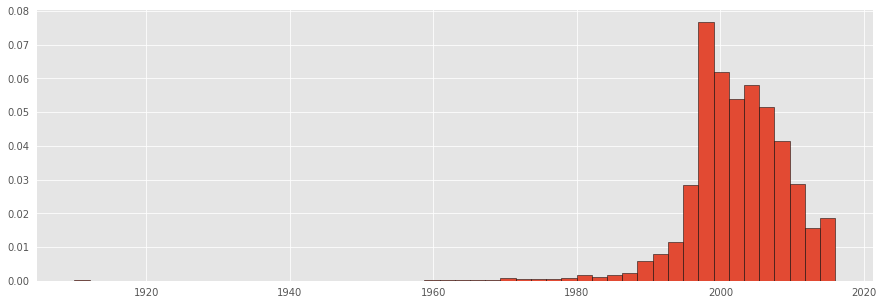

In [10]:
data.query('1899 < registration_year < 2017')['registration_year'].hist(bins=50, figsize=(15,5),density = True,edgecolor='black');

**Комментарий:**  целесообразно оставить данные в период 1960-2019, остальное отбросить.

In [11]:
data = data.drop(index = data.loc[ 1960 < (data['registration_year']  ) & (data['registration_year']<2019)].index).reset_index(drop=True) # дропнули года

#### Оценка поле power (мощность двигателя (л. с.))

**Комментарий:** поле **power** имеет нулевые и аномальные высокие мощности. Целесообразно такие значения  менять на медианные по моделям машин. Общепринятыми мощностями будем  считать диапазон от 5 до 500 ЛС. Для усреднения будем брать медиану  по связке полей brand+model+vehicle_type+registration_year, что более реалистично отразить мощность автомобиля. 

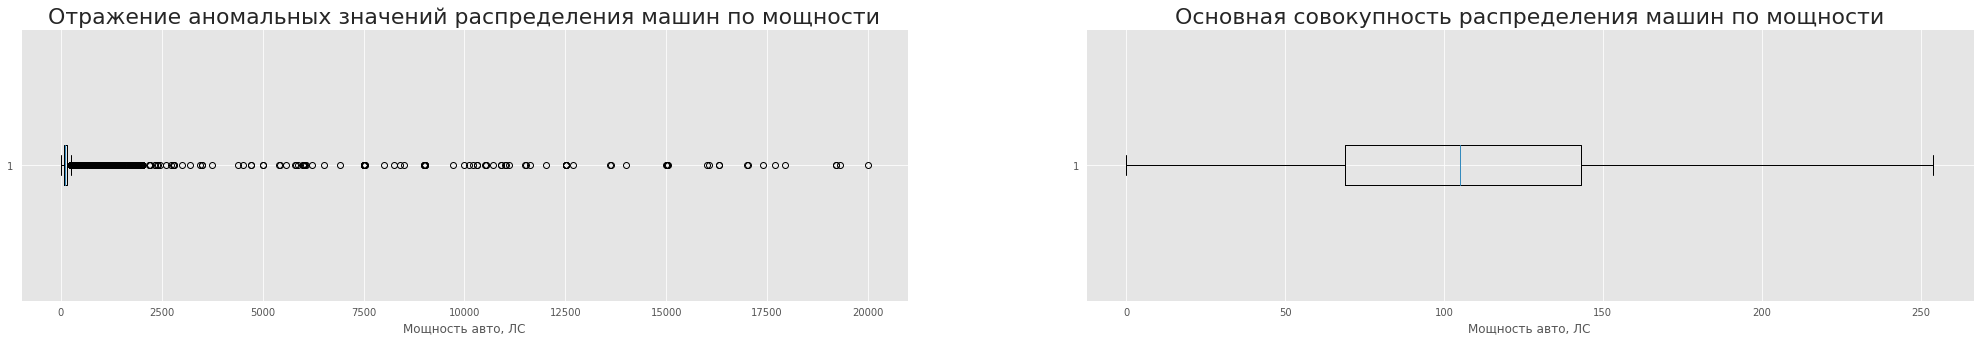

In [12]:
fig, axes = plt.subplots(1, 2,figsize=(35, 5));
axes[0].boxplot(x= data['power'],showfliers = True, vert =False);
axes[1].boxplot(x= data['power'],showfliers = False , vert =False);

axes[0].set_title('Отражение аномальных значений распределения машин по мощности', fontsize=22)
axes[0].set_xlabel('Мощность авто, ЛС');
axes[1].set_title('Основная совокупность распределения машин по мощности', fontsize=22)
axes[1].set_xlabel('Мощность авто, ЛС');

Заменим медианой

In [13]:
data['power_correct'] = round(data.groupby(['brand','model','vehicle_type','registration_year'])['power'].transform('median'),2)
data['power'] = np.where((500 > data['power']) & (data['power']<5), data['power_correct'], data['power'])

In [14]:
data = data.drop(index = data.loc[(data['power_correct'] <= 1)&(data['power']==0)&(data['vehicle_type'] == 'not defined')].index).reset_index(drop=True) #это можно удалить, слишком много отсутствующих значений.
# data.loc[(data['power_correct'] <= 1)&(data['power']==0)&(data['vehicle_type'] == 'not defined')&(data['not_repaired'] == 'not defined')&(data['model'] == 'not defined')] #это можно удалить, счлишком много отсутствующих значений.

**Комментарий:**  также выявлены экземпляры с нулевой мощьностью, по которым мощьность невозможно усреднить из-за единичных случаев. Плюс по этим  данным отсутствуют прочие критерии, данны достаточно грязные, целесообразно не принимать их в модель. Поэтому - drop.

#### Оценка поле price

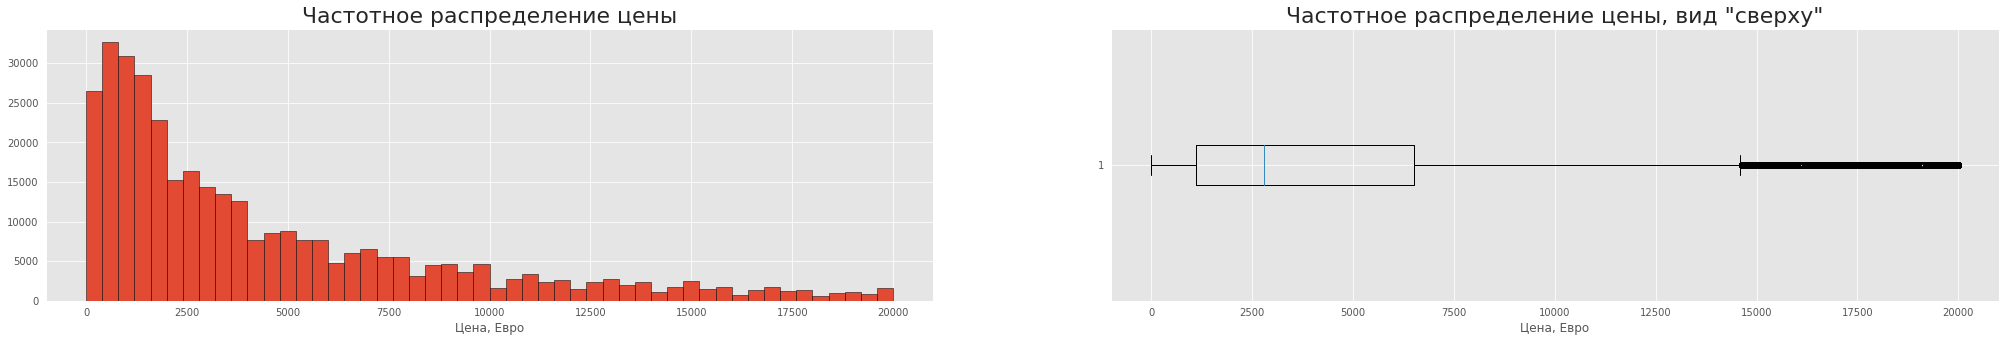

In [15]:
fig, axes = plt.subplots(1, 2,figsize=(35, 5));
axes[0].hist(data['price'],bins = 50 ,density = False,edgecolor='black');
axes[1].boxplot(x= data['price'],showfliers = True, vert =False);

axes[0].set_title('Частотное распределение цены', fontsize=22)
axes[0].set_xlabel('Цена, Евро');
axes[1].set_title('Частотное распределение цены, вид "сверху"', fontsize=22)
axes[1].set_xlabel('Цена, Евро');

**Комментарий:** поле **price** есть нулевые значения. Заменим нулевые значения на медианную цену в связке brand+model+registration_year, в  такой связке цена будет более корректно отражать стоимость авто. Также отбросим цену свыше 14000 евро, так эти данные ухудшают качество модели.

In [16]:
data['price_correct'] = round(data.groupby(['brand','model','vehicle_type','registration_year'])['price'].transform('median'),2) # возьмем медиану значение цены исходя из группы признаков.
data = data.drop(index = data.loc[(data['price_correct'] <= 1)&(data['price']==0)| (data['price_correct']>14000)].index).reset_index(drop=True)

**Комментарий:**  также выявлены экземпляры с нулевой ценой, по которым цену невозможно усреднить из-за единичных случаев. Аналогично, как и по полю **power** по этим  данным отсутствуют прочие критерии, данны достаточно грязные, целесообразно не принимать их в модель. Поэтому - drop.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331870 entries, 0 to 331869
Data columns (total 18 columns):
date_crawled          331870 non-null object
price                 331870 non-null int64
vehicle_type          331870 non-null object
registration_year     331870 non-null int64
gearbox               331870 non-null object
power                 331870 non-null float64
model                 331870 non-null object
kilometer             331870 non-null int64
registration_month    331870 non-null int64
fuel_type             331870 non-null object
brand                 331870 non-null object
not_repaired          331870 non-null object
date_created          331870 non-null object
number_of_pictures    331870 non-null int64
postal_code           331870 non-null int64
last_seen             331870 non-null object
power_correct         331870 non-null float64
price_correct         331870 non-null float64
dtypes: float64(3), int64(6), object(9)
memory usage: 45.6+ MB


### Оценка признаков, которые влияют на модель.

Такие поля  как:  date_crawled, registration_month, date_created, postal_code,last_seen не имеют смыслового значения для  решения задачи, поле number_of_pictures - все значения нули, поэтому эти столбцы удалим из расчетов в модели.

In [18]:
data.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code','last_seen','number_of_pictures','power_correct','price_correct'],axis =1, inplace = True)

In [27]:
list_categ = ['vehicle_type', 'gearbox','fuel_type','model','brand', 'not_repaired']
features_train = data.drop(['price'], axis=1)
target_train = data['price']
features_train,features_test, target_train,target_test = train_test_split(features_train,target_train, test_size=0.25, random_state=393)

In [28]:
numeric_list = ['registration_year','power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric_list])
features_train[numeric_list] = scaler.transform(features_train[numeric_list])
features_test[numeric_list] = scaler.transform(features_test[numeric_list])
features_train_numeric = np.array(features_train[numeric_list])
features_test_numeric = np.array(features_test[numeric_list])

In [29]:
enc = OneHotEncoder()
enc.fit(features_train[list_categ])
features_train_cat =enc.transform(features_train[list_categ]).toarray()
features_test_cat=enc.transform(features_test[list_categ]).toarray()

In [30]:
features_train = np.column_stack((features_train_numeric,features_train_cat))
features_test = np.column_stack((features_test_numeric,features_test_cat))

In [31]:
%%time
lr = LinearRegression().fit(features_train_numeric, np.array(target_train))
predict = lr.predict(features_test_numeric)
rmse = mean_squared_error(np.array(target_test), predict)**0.5
rmse

CPU times: user 25.3 ms, sys: 16.4 ms, total: 41.7 ms
Wall time: 33.1 ms


3643.675304136917

In [50]:
features_train.shape

(248902, 316)

### Кодирование категориальных признаков

Как мы видим есть категориальные признаки в столбцах  brand, model, vehicle_type, not_repaired и так далее . Принадлежность к категории логистическая регрессия вычисляет по формуле, состоящей из признаков. Они могут быть только численные. Поэтому применим технику прямого кодирования One-Hot Encoding путем создания фиктивных переменных, используем функцию pd.get_dummies()

In [41]:
list_categ = ['vehicle_type', 'gearbox','fuel_type','model','brand', 'not_repaired']# дропнем в том числе power_correct, price_correct
list_ohe = pd.get_dummies(data[list_categ],drop_first=True)
data_ohe = pd.concat([data,list_ohe],axis = 1)
data_ohe.drop(data_ohe[list_categ],axis=1, inplace = True)
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_not defined,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_not defined,not_repaired_yes
0,480,1993,75.00,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,9800,2004,163.00,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75.00,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69.00,90000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102.00,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Обучение моделей

Рассмотрим  несколько моделей для обучения:
- LinearRegression
- RandomForestRegressor
- CatBoostRegressor
- LGBMRegressor

### Разделени выборок на обучающую и  тестовую.

Выделим  целевой признак - price

In [42]:
features_train_ohe = data_ohe.drop(['price'], axis=1)
target_train_ohe = data_ohe['price']

Разделим выборки на обучающую тестовую в  соотношении 75/25

In [43]:
features_train_ohe,features_test_ohe, target_train_ohe,target_test_ohe = train_test_split(features_train_ohe,target_train_ohe, test_size=0.25, random_state=393)

In [44]:
display(
    features_train_ohe.shape,
    target_train_ohe.shape,
    features_test_ohe.shape,
    target_test_ohe.shape
)

(248902, 310)

(248902,)

(82968, 310)

(82968,)

### Масштабирование данных

Так как будем использовать линейную регрессию LinearRegression , то потребуется  масштабирование данных.

In [45]:
numeric_list = ['registration_year','power','kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric_list])
features_train_ohe[numeric_list] = scaler.transform(features_train_ohe[numeric_list])
features_test_ohe[numeric_list] = scaler.transform(features_test_ohe[numeric_list])
features_test_ohe.head(5)

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_not defined,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_not defined,not_repaired_yes
211066,0.23,-0.09,-3.10,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
240487,-0.08,0.13,0.55,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
45958,0.31,-0.09,0.55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273974,-0.06,0.12,0.55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
123966,-0.00,0.38,0.55,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### DecisionTreeRegressor

Обучим модель дерево решений

In [48]:
start_time = time.time()
dtr = DecisionTreeRegressor(random_state=393)
dtr.fit(features_train_ohe,target_train_ohe)
rmse_dtr_cv= cross_val_score(dtr, features_train_ohe,target_train_ohe,n_jobs = -1, cv=3,scoring = 'neg_mean_squared_error').mean()*(-1)
rmse_dtr_cv = rmse_dtr_cv**0.5
time_dtr_fit = time.time() - start_time
print('Время обучения: {:.0f}m {:.0f}s'.format(time_dtr_fit//60,time_dtr_fit%60))
print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_dtr_cv))

Время обучения: 0m 35s
Корень среднего квадрата ошибки 2007.23


In [37]:
start_time = time.time()
dtr = DecisionTreeRegressor(random_state=393)
dtr.fit(features_train,target_train)
rmse_dtr_cv= cross_val_score(dtr, features_train,target_train,n_jobs = -1, cv=3, scoring = 'neg_mean_squared_error').mean()*(-1)
rmse_dtr_cv = rmse_dtr_cv**0.5
time_dtr_fit = time.time() - start_time
print('Время обучения: {:.0f}m {:.0f}s'.format(time_dtr_fit//60,time_dtr_fit%60))
print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_dtr_cv))

Время обучения: 0m 53s
Корень среднего квадрата ошибки 2007.69


In [25]:
start_time = time.time()
dtr = DecisionTreeRegressor(random_state=393,criterion ='squared_error', max_depth = 10).fit(features_train_ohe,target_train_ohe)
time_dtr_fit = time.time() - start_time
predict = dtr.predict(features_test_ohe)
time_dtr_predict = time.time() - start_time-time_dtr_fit

rmse_dtr_dtr = mean_squared_error(target_test_ohe, predict, squared=False)

print('Время обучения: {:.0f}m {:.2f}s'.format(time_dtr_fit//60,time_dtr_fit%60))
print('Время предсказания: {:.0f}m {:.2f}s'.format(time_dtr_predict//60,time_dtr_predict%60))
print('Корень квадрата ошибки {:.2f}'.format(rmse_dtr_dtr))

Время обучения: 0m 6.39s
Время предсказания: 0m 0.29s
Корень квадрата ошибки 1955.01


### LinearRegression

Обучим модель линейную регрессию

In [26]:
start_time = time.time()

lr = LinearRegression()
rmse_lr_cv = cross_val_score(lr,features_train_ohe,target_train_ohe,n_jobs = -1,cv = 3, scoring = 'neg_root_mean_squared_error').mean()*(-1)
time_lr_fit = time.time() - start_time

print('Время обучения: {:.2f}s'.format(time_lr_fit))
print('Корень среднего квадрата ошибки {:.2f}'.format(rmse_lr_cv))

Время обучения: 15.67s
Корень среднего квадрата ошибки 2848.07


In [27]:
start_time = time.time()
lr = LinearRegression().fit(features_train_ohe,target_train_ohe)
time_lr_fit = time.time() - start_time
predict = lr.predict(features_test_ohe)
time_lr_predict = time.time() - start_time -time_lr_fit

rmse_lr = mean_squared_error(target_test_ohe, predict, squared=False)

print('Время обучения: {:.0f}m {:.2f}s'.format(time_lr_fit//60,time_lr_fit%60))
print('Время предсказания: {:.0f}m {:.2f}s'.format(time_lr_predict//60,time_lr_predict%60))
print('Корень квадрата ошибки {:.2f}'.format(rmse_lr))

Время обучения: 0m 6.93s
Время предсказания: 0m 0.20s
Корень квадрата ошибки 2845.37


### CatBoostRegressor

Разделим выборку на обучающую и на тестовую, выделим  целевой признак

In [28]:
features_train = data.drop(['price'], axis=1)
target_train = data['price']
features_train,features_test, target_train,target_test = train_test_split(features_train,target_train, test_size=0.25, random_state=393)

Выделим поля с категориальными признаками

In [29]:
list_categ = ['vehicle_type', 'gearbox','fuel_type','model','brand', 'not_repaired']

Применим GridSearchCV для подбора параметров для модели CatBoostRegressor, не будем рассматривать поиск значений по умолчанию модели CatBoostRegressor, так как  расчеты происходят долго.

In [30]:
grid = {'iterations': [100, 200],
        'learning_rate': [0.1, 0.4],
        'depth': [ 4, 6]}
start_time = time.time()
regressor = CatBoostRegressor(random_state=393,cat_features=list_categ,logging_level='Silent') 
print('Ожидайте, идет подгонка лучших параметров, около 5 минут')
clf = GridSearchCV(regressor, grid, scoring='neg_root_mean_squared_error',n_jobs = -1,cv=3)
clf.fit(features_train,target_train)
time_clf = time.time() - start_time
print("Лучшие параметры:",clf.best_params_)
print('Наименшая ошибка лучшей модели, евро', clf.best_score_*-1)
print('Время подгонки факт: {:.0f}m {:.0f}s'.format(time_clf//60,time_clf%60))

Ожидайте, идет подгонка лучших параметров, около 5 минут
Лучшие параметры: {'depth': 6, 'iterations': 200, 'learning_rate': 0.4}
Наименшая ошибка лучшей модели, евро 1647.8928184526728
Время подгонки факт: 5m 22s


In [31]:
start_time = time.time()

model_cat = CatBoostRegressor(random_seed=393,loss_function='RMSE',logging_level='Silent',learning_rate=0.4,cat_features = list_categ,depth =6, iterations= 200)
model_cat.fit(features_train,target_train)

time_cbr_fit = time.time() - start_time
predict = model_cat.predict(features_test)
time_cbr_predict = time.time() - start_time -time_cbr_fit

rmse_cbr = mean_squared_error(target_test, predict, squared=False)

print('Время обучения: {:.0f}m {:.0f}s'.format(time_cbr_fit//60,time_cbr_fit%60))
print('Время предсказания: {:.0f}m {:.2f}s'.format(time_cbr_predict//60,time_cbr_predict%60))
print('Корень квадрата ошибки {:.2f}'.format(rmse_cbr))

Время обучения: 0m 39s
Время предсказания: 0m 0.19s
Корень квадрата ошибки 1625.03


### LightGBM

Трансформируем категриальные признаки


In [33]:
list_categ_gbm = ['vehicle_type', 'gearbox','fuel_type','model','brand', 'not_repaired']
data[list_categ_gbm] = data[list_categ_gbm].astype('category')
features_train = data.drop(['price'], axis=1)
target_train = data['price']
features_train,features_test, target_train,target_test = train_test_split(features_train,target_train, test_size=0.25, random_state=393)

Обучим модель без параметров

In [34]:
start_time = time.time()

lgbm_reg = LGBMRegressor(random_state=393, num_leaves=30,categorical_feature=list_categ_gbm)
rmse_lgbm_cv= cross_val_score(lgbm_reg, features_train,target_train,n_jobs = -1, cv=3,scoring = 'neg_root_mean_squared_error').mean()*(-1)

time_lgbm = time.time() - start_time

print('Время обучения: {:.0f}m {:.0f}s'.format(time_lgbm//60,time_lgbm%60))
print('Корень квадрата ошибки {:.2f}'.format(rmse_lgbm_cv))

Время обучения: 0m 3s
Корень квадрата ошибки 1643.06


Подберем параметры

In [35]:
regressor = LGBMRegressor(random_state=393,categorical_feature=list_categ_gbm) 
params = [{'n_estimators':[100,200,300], 
                'learning_rate':[0.01,0.1, 0.3, 0.5],
                'num_leaves':[10,20,30]}]
    
print('Ожидайте, идет подгонка лучших параметров')
clf = GridSearchCV(regressor, params, scoring='neg_root_mean_squared_error',n_jobs = -1,cv=3)
clf.fit(features_train,target_train)
print("Лучшие параметры:",clf.best_params_)
print('Наименшая ошибка лучшей модели, евро', clf.best_score_*-1)


Ожидайте, идет подгонка лучших параметров


c:\users\integro\appdata\local\programs\python\python39\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
c:\users\integro\appdata\local\programs\python\python39\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Лучшие параметры: {'learning_rate': 0.3, 'n_estimators': 300, 'num_leaves': 30}
Наименшая ошибка лучшей модели, евро 1605.1637988838258


In [36]:


start_time = time.time()
lgbm_reg = LGBMRegressor(random_state=393,categorical_feature=list_categ,n_estimators = 300,learning_rate=0.3,num_leaves=30)
lgbm_reg.fit(features_train,target_train)

time_lgbm_fit = time.time() - start_time

predict = lgbm_reg.predict(features_test)

time_lgbm_predict = time.time() - start_time-time_lgbm_fit
rmse_lgbm_reg = mean_squared_error(target_test, predict, squared=False)

print('Время обучения: {:.0f}m {:.2f}s'.format(time_lgbm_fit//60,time_lgbm_fit%60))
print('Время предсказания: {:.0f}m {:.2f}s'.format(time_lgbm_predict//60,time_lgbm_predict%60))
print('Корень квадрата ошибки {:.2f}'.format(rmse_lgbm_reg))

Время обучения: 0m 1.45s
Время предсказания: 0m 0.50s
Корень квадрата ошибки 1578.54


## Анализ моделей

Предварительно проверим модель на адекватность, сделаем предсказния по среднему значению.

In [37]:
start_time = time.time()
dummy_regr = DummyRegressor(strategy="mean").fit(features_train, target_train)
time_dummy_fit = time.time() - start_time
preds = dummy_regr.predict(features_test)
time_dummy_predict = time.time() - start_time- time_dummy_fit
dummy_rmse = mean_squared_error(target_test, preds, squared=False)
dummy_rmse

3883.5315882348627

**Вывод:** в констаной  модели, действительно имеем большую ошибку, 4525 евро.

In [38]:
dtr_list = [rmse_dtr_dtr,time_dtr_fit,time_dtr_predict]
lr_list = [rmse_lr,time_lr_fit,time_lr_predict]
lgbm_list = [rmse_lgbm_reg,time_lgbm_fit,time_lgbm_predict]
cbr_list = [rmse_cbr, time_cbr_fit,time_cbr_predict]
dummy_list = [dummy_rmse,time_dummy_fit,time_dummy_predict]

In [39]:
final_table = pd.DataFrame(data=[dtr_list,lr_list, lgbm_list, cbr_list,dummy_list],
                       columns=['RMSE_евро', 'Время обучения','Время предсказания'],
                      index=['Дерево решений','Линейная_регрессия', 'Light_GBM', 'CatBoost','Константная_mean'])
final_table.sort_values('RMSE_евро')

,RMSE_евро,Время обучения,Время предсказания
Light_GBM,"1,578.54",1.45,0.50
CatBoost,"1,625.03",39.46,0.19
Дерево решений,"1,955.01",6.39,0.29
Линейная_регрессия,"2,845.37",6.93,0.20
Константная_mean,"3,883.53",0.00,0.00


# Итог

По результатам формирования моделей предсказания стоимости авто:
- наилучшее время обучения и RMSE показала  Light_GBM 
- наилучшее время предсказания показала модель CatBoost
- остальные модели показали качество предсказания значительно хуже, а также более долгое обучение.

На основании этого бизнесу на обсуждение будет предложена модель  Light_GBM и CatBoost. Решение целесообразно принимать в зависимости, что будет приоритетнее скорость предсказаний или точность .